In [4]:
import pandas as pd
import numpy as np

import datetime 
import time

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import shuffle


In [5]:
!unzip -n archive.zip

Archive:  archive.zip


Considering the order of rating preference for an user being defined in the order of viewing-->addtocart and then transaction

Log scale signifies that 10 number of views is equivalent to 1 instance of addting to cart
Same analogy can be applied to cart:transaction

We can keep duplicates of users and items and describe preference order as 1,2 and 3 for viewing, adding and transaction but then tis orinality will make less sense.

Else we can play with these values


In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
events_df = pd.read_csv('./events.csv')

events_df.head()
events_df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [8]:
events_df = pd.read_csv('./events.csv')

events_df.head()
# events_df.shape


events_df.event.value_counts()
# events_df.nunique()
#buying as 3,add_to_cart=2,view=1



# events_df.dropna(inplace=True)
events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
# events_df.drop_duplicates(subset=
                          # ['visitorid','itemid']).shape[0]/events_df.shape[0]

df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()

In [9]:
df_events.describe().round()

# df_events.

,visitorid,itemid,rating
count,2145179.0,2145179.0,2145179.0
mean,702031.0,234614.0,0.0
std,405680.0,134116.0,1.0
min,0.0,3.0,0.0
25%,350566.0,117673.0,0.0
50%,702113.0,235401.0,0.0
75%,1052906.0,350399.0,0.0
max,1407579.0,466867.0,142.0


In [10]:
# df_events.rating.value_counts().astype(float).plot(kind='hist',bins=20)

In [11]:
df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,1,10,1000],right=False,
                      labels=[1,2,3],
                      include_lowest=True)
#Views,addt0cart,transaction

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)
df_events.cum_rating.value_counts()
df_events.loc[:,'cum_rating']=df_events.loc[:,'cum_rating'].astype(int)
#just_views,higher_views,addt0cart,transaction

In [12]:
df_events.cum_rating.value_counts()


1    1801793
2     277000
3      45071
4      21315
Name: cum_rating, dtype: int64

In [13]:
df_events=pd.concat([df_events[df_events.cum_rating==1].sample(int(0.1*df_events[df_events.cum_rating==1].shape[0])),
                     df_events[df_events.cum_rating!=1]])
df_events.cum_rating.value_counts()


2    277000
1    180179
3     45071
4     21315
Name: cum_rating, dtype: int64

Need to have zero start and continuous,increment by 1
items and users ids do as to formulate embedder matrix

In [14]:
df_events.columns

df_events.visitorid = pd.Categorical(df_events.visitorid)
df_events['new_vis_id'] = df_events.visitorid.cat.codes

df_events.itemid = pd.Categorical(df_events.itemid)
df_events['new_item_id'] = df_events.itemid.cat.codes

In [15]:
df_events.head()

,visitorid,itemid,rating,cum_rating,new_vis_id,new_item_id
1209879,792259,167127,0.1,1,212974,43057
1905632,1248178,418317,0.1,1,335388,107818
684132,447588,255330,0.1,1,120118,65861
9734,6599,69408,0.1,1,1781,17788
1603641,1049318,15898,0.1,1,282081,4030


In [16]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values

In [17]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
N,M

(378743, 120138)

In [18]:
# Make a neural network

# User input
u = Input(shape=(1,))

# Movie input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
# split the data
#will create hold out set later, need to devise a way
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating

In [20]:
pow(0.6,1/2)

0.7745966692414834

In [21]:
r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/25
435/435 - 4s - loss: 0.5852 - val_loss: 0.5641 - 4s/epoch - 10ms/step
Epoch 2/25
435/435 - 2s - loss: 0.5618 - val_loss: 0.5642 - 2s/epoch - 5ms/step
Epoch 3/25
435/435 - 2s - loss: 0.5618 - val_loss: 0.5641 - 2s/epoch - 4ms/step
Epoch 4/25
435/435 - 2s - loss: 0.5576 - val_loss: 0.5551 - 2s/epoch - 5ms/step
Epoch 5/25
435/435 - 2s - loss: 0.5431 - val_loss: 0.5496 - 2s/epoch - 5ms/step
Epoch 6/25
435/435 - 2s - loss: 0.5317 - val_loss: 0.5523 - 2s/epoch - 4ms/step
Epoch 7/25
435/435 - 2s - loss: 0.5180 - val_loss: 0.5749 - 2s/epoch - 5ms/step
Epoch 8/25
435/435 - 2s - loss: 0.4999 - val_loss: 0.5663 - 2s/epoch - 4ms/step
Epoch 9/25
435/435 - 2s - loss: 0.4785 - val_loss: 0.5881 - 2s/epoch - 5ms/step
Epoch 10/25
435/435 - 2s - loss: 0.4569 - val_loss: 0.6197 - 2s/epoch - 4ms/step
Epoch 11/25
435/435 - 2s - loss: 0.4343 - val_loss: 0.6335 - 2s/epoch - 5ms/step
Epoch 12/25
435/435 - 2s - loss: 0.4104 - val_loss: 0.6716 - 2s/epoch - 5ms/step
Epoch 13/25
435/435 - 2s - loss: 0.3

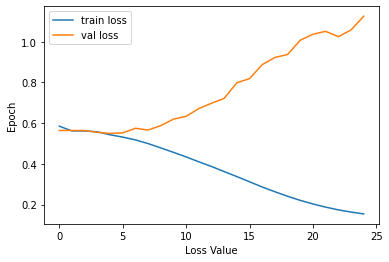

In [22]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.xlabel('Loss Value')
plt.ylabel('Epoch')
plt.legend()
plt.show()

With lerger training data

# HIT RATE

In [50]:
np.repeat([1,2],10)




array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [87]:
df_test=pd.DataFrame({
    'U':test_user,'I':test_item,'R':
    test_ratings},
      )

df_test=df_test[df_test.R>=3].iloc[:5000,]


y_pred=model.predict(
  x=[np.repeat(df_test.U.values[:5000],5000), 
          np.tile(df_test.I.values,5000)])

In [139]:
df_pred=pd.DataFrame({'U':np.repeat(df_test.U.values[:5000],5000),
              'I':np.tile(df_test.I.values,5000),
              'pred_r':y_pred.reshape(-1,)})

def top_n(df,n=20):
  df=df.sort_values('pred_r',ascending=False)
  return pd.Series(df['I'].iloc[:n].values)


df_top_n=df_pred.groupby(['U']).apply(lambda d: top_n(d,20))


In [140]:
df_top_n=df_top_n.merge(df_test,how='left',right_on='U',left_index=True).set_index('U')
df_top_n.drop(['R'],axis=1,inplace=True)
df_top_n=df_top_n[~df_top_n.index.duplicated(keep='first')]
df_top_n

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,I
U,,,,,,,,,,,,,,,,,,,,,
113,44693,55906,7311,99158,83106,114736,75900,34172,34216,34216,14710,25107,74540,98951,11412,71573,4009,115266,115266,8303,59783
116,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,74540,14710,98951,71573,11412,4009,115266,115266,55974,14211
212,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,63437
322,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,74540,14710,71573,98951,11412,4009,55974,115266,115266,7647
384,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,83918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378504,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,53786
378557,44693,55906,7311,99158,83106,114736,75900,34172,34216,34216,14710,25107,74540,98951,11412,71573,4009,8303,107431,115266,3147
378610,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,47334


In [142]:
# df_top_n.apply(lambda s: any(s.drop('I')==s['I']),axis=1).sum()

temp_id=df_top_n.apply(lambda s: any(s.drop('I')==s['I']),axis=1)
temp_df=pd.concat([df_top_n.loc[temp_id],df_top_n.loc[~temp_id].sample(200)]).sample(frac=1)

In [107]:
hit_rate=df_top_n.apply(lambda s: any(s.drop('I')==s['I']),axis=1).sum()/df_top_n.shape[0]
hit_rate

0.003805899143672693

In [148]:
temp_df.style.apply(lambda x: ['background: lightgreen' if any(x.drop('I')==x['I'])
                              else 'background: red' for i in x], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,I
U,,,,,,,,,,,,,,,,,,,,,
113,44693,55906,7311,99158,83106,114736,75900,34172,34216,34216,14710,25107,74540,98951,11412,71573,4009,115266,115266,8303,59783
116,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,74540,14710,98951,71573,11412,4009,115266,115266,55974,14211
212,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,63437
322,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,74540,14710,71573,98951,11412,4009,55974,115266,115266,7647
384,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,83918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378504,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,53786
378557,44693,55906,7311,99158,83106,114736,75900,34172,34216,34216,14710,25107,74540,98951,11412,71573,4009,8303,107431,115266,3147
378610,44693,55906,7311,99158,83106,114736,75900,34216,34216,34172,25107,71573,74540,14710,98951,11412,55974,4009,115266,115266,47334
